In [56]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from tqdm import tqdm_notebook

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate,BatchNormalization, Activation, ZeroPadding2D, concatenate
from keras.backend import get_session, random_normal,ones_like,zeros_like,mean
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, History

In [79]:
Images = os.listdir('all-images/')
annos = os.listdir('Annotation/') 

In [80]:
len(Images)

20581

In [81]:
np.random.seed(2019)
Images = np.sort(Images)[1:]
x = np.random.choice(np.arange(20580),10000)
np.random.seed(None)

In [82]:
img = Image.open('all-images/' + 'n02085620_10074.jpg')

In [83]:
img.size

(333, 500)

In [84]:
idxIn, namesIn = 0, []
imagesIn = np.zeros((25000,64,64,3))

In [85]:
for k in tqdm_notebook(range(len(x))):
    img = Image.open('all-images/' + Images[x[k]])
    w,h = img.size[0], img.size[1]
    if (k%2==0)|(k%3==0):
        w2, h2 = 100, int(h/(w/100))
        a, b = 18, 0          
    else:
        a, b = 0 , 0
        if w<h:
            w2, h2 = 64, int((64/w)*h)
            b = (h2-64)//2
        else:
            h2, w2 = 64, int((64/h)*w)
            a = (w2-64)//2
    img = img.resize((w2,h2), Image.ANTIALIAS)
    img = img.crop((0+a, 0+b, 64+a, 64+b))    
    imagesIn[idxIn,:,:,:] = np.asarray(img)
    namesIn.append(Images[x[k]])
    idxIn += 1

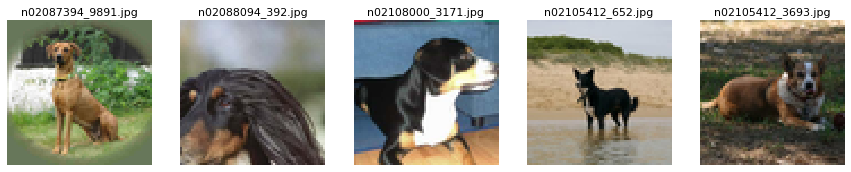

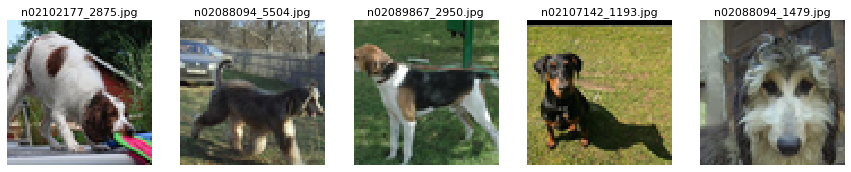

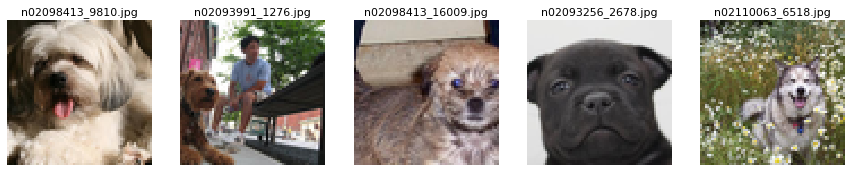

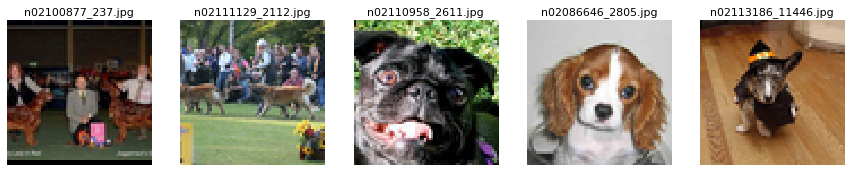

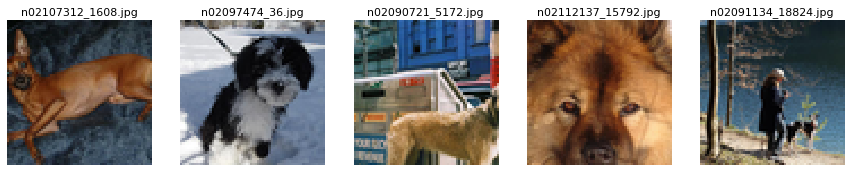

In [86]:
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8'))
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]],fontsize=11)
        plt.imshow(img)
    plt.show()


In [87]:
IMG_SIZE = Input((64*64*3,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = (10000,)

In [88]:
_input = Dense(12288, activation='sigmoid')(IMG_SIZE_2) 
input_layer = Reshape((2,12288,1))(concatenate([IMG_SIZE,_input]))
discriminator = Conv2D(filters = 1, kernel_size=[2,1],use_bias=False, name = 'layer_1')(input_layer)
out = Flatten()(discriminator)

model_discriminator = Model([IMG_SIZE,IMG_SIZE_2],out)
model_discriminator.get_layer('layer_1').trainable = False
model_discriminator.get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
model_discriminator.summary()
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 12288)        122892288   input_16[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24576)        0           input_15[0][0]                   
                                                                 dense_8[0][0]             

In [124]:
_input = Input(NOISE_SIZE)
generated = Dense(12288, activation='linear')(_input)
out = Reshape((10000,))(_input)

model_generator = Model(_input,[generated,out])
model_generator.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 12288)        122892288   input_29[0][0]                   
__________________________________________________________________________________________________
reshape_14 (Reshape)            (None, 10000)        0           input_29[0][0]                   
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


In [52]:
(imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))[0].shape

(12288,)

In [94]:
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.random.rand(10000,10000)
train_X = np.zeros((10000,10000))
for i in range(10000): 
    train_X[i,i] = 1
zeros = np.zeros((10000,12288))

In [95]:
LearningRateScheduler(lambda x: 0.5)

In [96]:
lr = 0.5
for k in range(5):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 10,batch_size = 128, callbacks=[LR_Scheduler], verbose=1)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: 
        lr = 0.1

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 73s 7ms/sample - loss: 0.7504
Epoch 2/10
10000/10000 [==============================] - 65s 6ms/sample - loss: 0.6291
Epoch 3/10
10000/10000 [==============================] - 71s 7ms/sample - loss: 0.5925
Epoch 4/10
10000/10000 [==============================] - 64s 6ms/sample - loss: 0.5712
Epoch 5/10
10000/10000 [==============================] - 59s 6ms/sample - loss: 0.5582
Epoch 6/10
10000/10000 [==============================] - 58s 6ms/sample - loss: 0.5499
Epoch 7/10
10000/10000 [==============================] - 57s 6ms/sample - loss: 0.5445
Epoch 8/10
10000/10000 [==============================] - 55s 5ms/sample - loss: 0.5407
Epoch 9/10
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.5382
Epoch 10/10
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.5363
Epoch 10 /50 - loss = 0.5363275300979614
Train on 10000 samples
Epoch 1/10
10000/10000 [========

KeyboardInterrupt: 

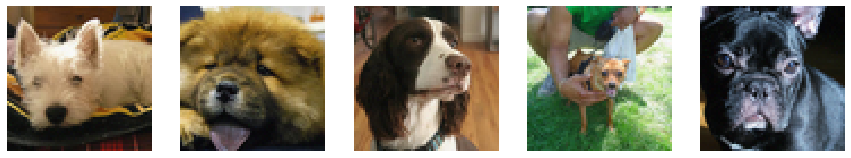

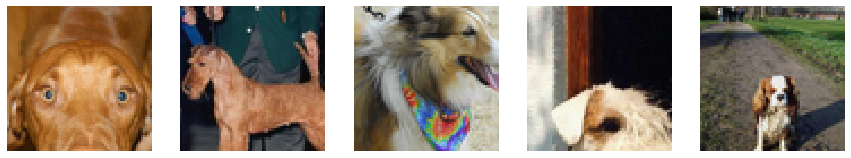

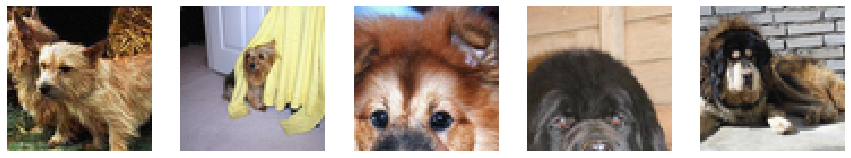

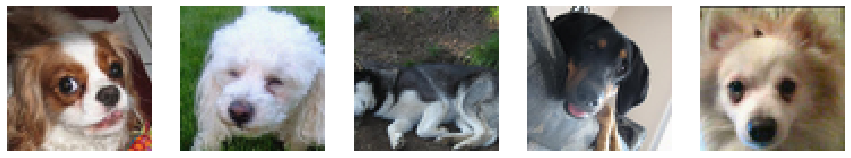

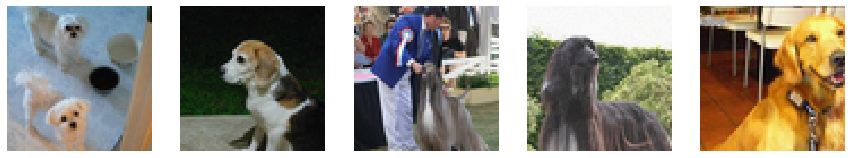

In [97]:
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [65]:
NOISE_SIZE

(10000,)

In [125]:
model_discriminator.trainable = False 

z = Input(shape=NOISE_SIZE,)
img = model_generator(z)
real = model_discriminator(img)

gan = Model(z, real)
gan.get_layer('model_10').get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

gan.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
model_23 (Model)                [(None, 12288), (Non 122892288   input_30[0][0]                   
__________________________________________________________________________________________________
model_10 (Model)                (None, 12288)        122892290   model_23[1][0]                   
                                                                 model_23[1][1]                   
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


In [106]:
train = np.zeros((10000,10000))
for i in range(10000): 
    train[i,i] = 1
zeros = np.zeros((10000,12288))

Train on 10000 samples
10000/10000 [==============================] - 49s 5ms/sample - loss: 39.3695


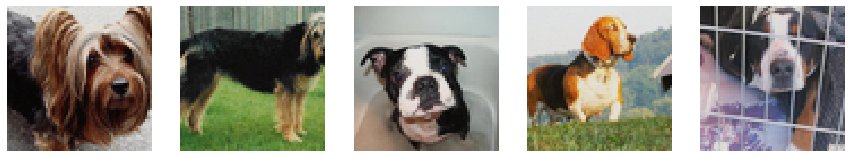

Train on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 48s 5ms/sample - loss: 32.9761
Epoch 2/2
10000/10000 [==============================] - 45s 4ms/sample - loss: 27.6923


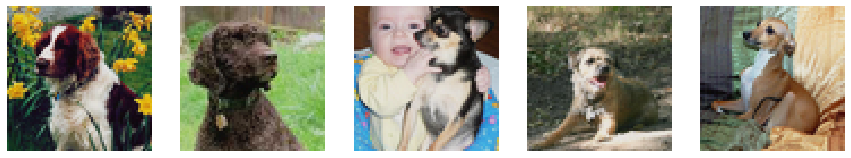

Train on 10000 samples
Epoch 1/4
10000/10000 [==============================] - 51s 5ms/sample - loss: 23.3176
Epoch 2/4
10000/10000 [==============================] - 48s 5ms/sample - loss: 19.6562
Epoch 3/4
10000/10000 [==============================] - 49s 5ms/sample - loss: 16.5930
Epoch 4/4
10000/10000 [==============================] - 48s 5ms/sample - loss: 14.0546


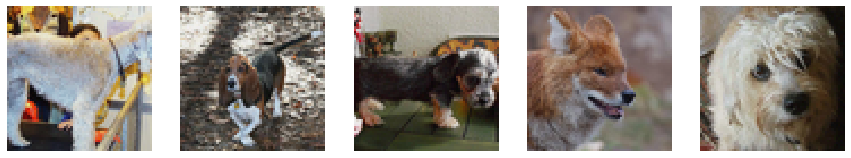

Train on 10000 samples
Epoch 1/8
10000/10000 [==============================] - 47s 5ms/sample - loss: 11.9671
Epoch 2/8
10000/10000 [==============================] - 46s 5ms/sample - loss: 10.2028
Epoch 3/8
10000/10000 [==============================] - 47s 5ms/sample - loss: 8.7134
Epoch 4/8
10000/10000 [==============================] - 50s 5ms/sample - loss: 7.4797
Epoch 5/8
10000/10000 [==============================] - 48s 5ms/sample - loss: 6.4478
Epoch 6/8
10000/10000 [==============================] - 49s 5ms/sample - loss: 5.5903
Epoch 7/8
10000/10000 [==============================] - 48s 5ms/sample - loss: 4.8737
Epoch 8/8
10000/10000 [==============================] - 47s 5ms/sample - loss: 4.2603


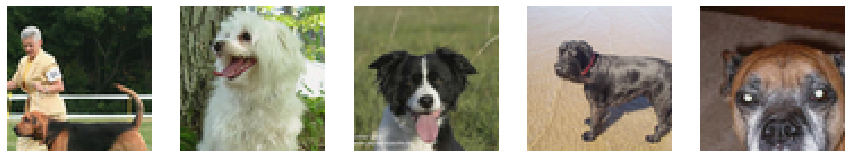

Train on 10000 samples
Epoch 1/16
10000/10000 [==============================] - 43s 4ms/sample - loss: 3.7462
Epoch 2/16
10000/10000 [==============================] - 51s 5ms/sample - loss: 3.3145
Epoch 3/16
10000/10000 [==============================] - 49s 5ms/sample - loss: 2.9418
Epoch 4/16
10000/10000 [==============================] - 49s 5ms/sample - loss: 2.6063
Epoch 5/16
10000/10000 [==============================] - 48s 5ms/sample - loss: 2.3349
Epoch 6/16
10000/10000 [==============================] - 48s 5ms/sample - loss: 2.1018
Epoch 7/16
10000/10000 [==============================] - 45s 4ms/sample - loss: 1.8997
Epoch 8/16
10000/10000 [==============================] - 48s 5ms/sample - loss: 1.7208
Epoch 9/16
10000/10000 [==============================] - 47s 5ms/sample - loss: 1.5664
Epoch 10/16
10000/10000 [==============================] - 49s 5ms/sample - loss: 1.4265
Epoch 11/16
10000/10000 [==============================] - 48s 5ms/sample - loss: 1.3002
Epoch 1

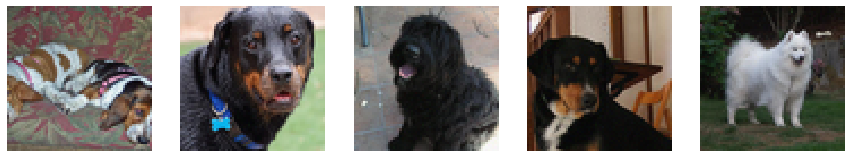

Train on 10000 samples
Epoch 1/32
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.7822
Epoch 2/32
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 3/32
10000/10000 [==============================] - 46s 5ms/sample - loss: 0.7822
Epoch 4/32
10000/10000 [==============================] - 45s 5ms/sample - loss: 0.7822
Epoch 5/32
10000/10000 [==============================] - 47s 5ms/sample - loss: 0.7822
Epoch 6/32
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 7/32
10000/10000 [==============================] - 47s 5ms/sample - loss: 0.7822
Epoch 8/32
10000/10000 [==============================] - 47s 5ms/sample - loss: 0.7822
Epoch 9/32
10000/10000 [==============================] - 45s 4ms/sample - loss: 0.7822
Epoch 10/32
10000/10000 [==============================] - 44s 4ms/sample - loss: 0.7822
Epoch 11/32
10000/10000 [==============================] - 40s 4ms/sample - loss: 0.7822
Epoch 1

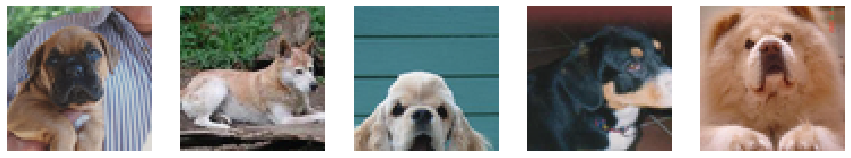

Train on 10000 samples
Epoch 1/64
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.7822
Epoch 2/64
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.7822
Epoch 3/64
10000/10000 [==============================] - 47s 5ms/sample - loss: 0.7822
Epoch 4/64
10000/10000 [==============================] - 45s 4ms/sample - loss: 0.7822
Epoch 5/64
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.7822
Epoch 6/64
10000/10000 [==============================] - 47s 5ms/sample - loss: 0.7822
Epoch 7/64
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.7822
Epoch 8/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 9/64
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.7822
Epoch 10/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 11/64
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.7822
Epoch 1

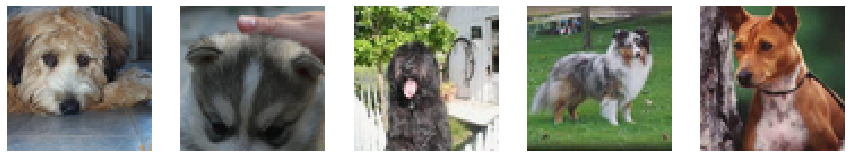

Train on 10000 samples
Epoch 1/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 2/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 3/64
10000/10000 [==============================] - 55s 5ms/sample - loss: 0.7822
Epoch 4/64
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.7822
Epoch 5/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 6/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 7/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 8/64
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.7822
Epoch 9/64
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.7822
Epoch 10/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 11/64
10000/10000 [==============================] - 52s 5ms/sample - loss: 0.7822
Epoch 1

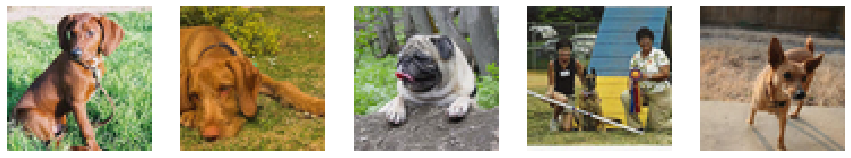

Train on 10000 samples
Epoch 1/64
10000/10000 [==============================] - 44s 4ms/sample - loss: 0.7822
Epoch 2/64
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.7822
Epoch 3/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 4/64
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.7822
Epoch 5/64
10000/10000 [==============================] - 45s 5ms/sample - loss: 0.7822
Epoch 6/64
10000/10000 [==============================] - 42s 4ms/sample - loss: 0.7822
Epoch 7/64
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.7822
Epoch 8/64
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.7822
Epoch 9/64
10000/10000 [==============================] - 54s 5ms/sample - loss: 0.7822
Epoch 10/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 11/64
10000/10000 [==============================] - 50s 5ms/sample - loss: 0.7822
Epoch 1

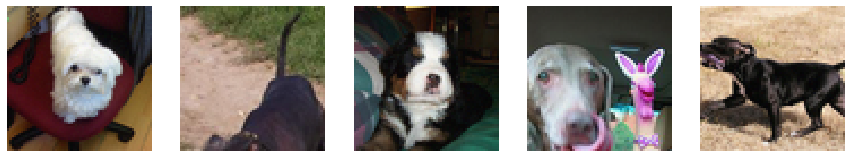

Train on 10000 samples
Epoch 1/64
10000/10000 [==============================] - 50s 5ms/sample - loss: 0.7822
Epoch 2/64
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.7822
Epoch 3/64
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.7822
Epoch 4/64
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.7822
Epoch 5/64
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.7822
Epoch 6/64
10000/10000 [==============================] - 42s 4ms/sample - loss: 0.7822
Epoch 7/64
10000/10000 [==============================] - 45s 5ms/sample - loss: 0.7822
Epoch 8/64
10000/10000 [==============================] - 53s 5ms/sample - loss: 0.7822
Epoch 9/64
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.7822
Epoch 10/64
10000/10000 [==============================] - 45s 4ms/sample - loss: 0.7822
Epoch 11/64
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.7822
Epoch 1

In [ ]:
lr = 1.0
ep = 1
for step in range(15):
    
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[LR_Scheduler], verbose=1)       
          
    plt.figure(figsize=(15,3))
    for j in range(5):
        zz = np.zeros((10000))
        zz[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_generator.predict(zz.reshape((-1,10000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()
        
        
    ep *= 2
    if ep>=32: 
        lr = 0.01
    if ep>64: 
        ep = 64